# EMIT Notebook for CyAN Comparison

Written by Kelly Luis     

Description: A Jupyter Notebook for accessing and implementing Cyanobacteria index and comparing with CyAN Merged S3 

In [1]:
# Import Libraries
import os
import earthaccess
import xarray as xr
from osgeo import gdal
import rasterio as rio
import rioxarray as rxr
import folium.plugins
import pandas as pd
import geopandas as gpd
import math
import sys
from matplotlib import pyplot as plt
import requests
import s3fs
import netCDF4 as nc
import numpy as np
import holoviews as hv
import hvplot.xarray

sys.path.append('/home/jovyan/EMIT-Data-Resources/python/modules')
from emit_tools import emit_xarray
import emit_aqua 

In [2]:
import earthaccess
earthaccess.login(persist=True)

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 01/15/2024
Using .netrc file for EDL


In [3]:
# Set Up S3 Access
s3_cred_endpoint = {
    'podaac':'https://archive.podaac.earthdata.nasa.gov/s3credentials',
    'gesdisc': 'https://data.gesdisc.earthdata.nasa.gov/s3credentials',
    'lpdaac':'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials',
    'ornldaac': 'https://data.ornldaac.earthdata.nasa.gov/s3credentials',
    'ghrcdaac': 'https://data.ghrc.earthdata.nasa.gov/s3credentials'}

# Define Function 
def get_temp_creds(provider):
    return requests.get(s3_cred_endpoint[provider]).json()

temp_creds_req = get_temp_creds('lpdaac')

# Pass Authentication to s3fs
fs_s3 = s3fs.S3FileSystem(anon=False, 
                          key=temp_creds_req['accessKeyId'], 
                          secret=temp_creds_req['secretAccessKey'], 
                          token=temp_creds_req['sessionToken'])

In [74]:
# San Luis Reservoir 
s3_list = ["s3://lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20220814T160453_2222611_003/EMIT_L2A_RFL_001_20220814T160453_2222611_003.nc"
    , "s3://lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20231008T174613_2328112_003/EMIT_L2A_RFL_001_20231008T174613_2328112_003.nc"]

In [75]:
# Open s3
fp = fs_s3.open(s3_list[1], mode='rb')
ds = emit_xarray(fp, ortho=True)
ds['reflectance'].data[:,:,ds['good_wavelengths'].data==0] = np.nan

In [76]:
# Coordinates
N = 37.107607
E = -121.011731
S =37.007555
W = -121.180912

ds_sub = ds.sel(longitude=slice(W, E), latitude=slice(N, S))

# Add land, cirrus, and cloud masks
ds_sub = emit_aqua.mask_aqua(ds_sub)

In [77]:
ds_sub['CI'], ds_sub['counts'] = emit_aqua.CIcyano(ds_sub)

In [78]:
map = ds_sub.CI.where(ds_sub.land_mask == 1).where(ds_sub.CI > 0).hvplot(x='longitude', y='latitude', aspect = 'equal', frame_width=400, cmap='Viridis')
map

:Image   [longitude,latitude]   (CI)

## Query CyAN API

The updates to OBDAAC are lagged and only able to pull through May 2023

In [81]:
from datetime import datetime

datetime_str = ds_sub.time_coverage_start
datetime_object = pd.to_datetime(datetime_str)
date = datetime.date(datetime_object).strftime('%Y-%m-%d')

'2023-10-08'

In [82]:
# Search Example using Bounding Box
results = earthaccess.search_data(
    short_name='MERGED_S3_OLCI_L3m_CYAN',
    bounding_box=(W, S, E, N),
    temporal=(date,date),
    count=100
)

Granules found: 0


In [11]:
cyan_results_urls = [granule.data_links() for granule in results]

filtered_asset_links = []
# Pick Desired Assets (leave _ on to distinguish from full CONUS retrieval
desired_assets = ['L3m_DAY_CYAN_CI_cyano_CYAN_CONUS_300m_']
# Step through each sublist (granule) and filter based on desired assets.
for n, granule in enumerate(cyan_results_urls):
    for url in granule: 
        asset_name = url.split('/')[-1]
        if any(asset in asset_name for asset in desired_assets):
            filtered_asset_links.append(url)

In [12]:
# Retrieve granule asset ID from URL (to maintain existing naming convention)
fs = earthaccess.get_fsspec_https_session()

for url in filtered_asset_links:
    granule_asset_id = url.split('/')[-1]
    # Download the Granule Asset if it doesn't exist
    if not os.path.isfile(granule_asset_id):
        r = requests.get(url)
        open(granule_asset_id , 'wb').write(r.content)

### Load CyaN Retreival


0 indicates below threshold of CI detection limits (grey color)
1-253 are data
254 is land (brown)
255 are no data (black--e.g., a cloudy pixel)
To convert Digital Number (DN) to CI_cyano:

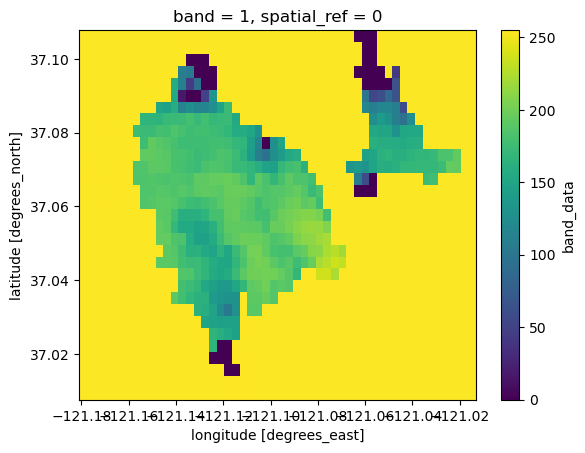

In [35]:
# Open Rasterio
cyan_rasterio = xr.open_dataset(granule_asset_id)

# Reproject to Geodetic (NEED TO DOUBLE CHECK THIS ONE)
da = cyan_rasterio.rio.reproject("EPSG:4326")

# Slice for Bounding Box of Interest
da_sub = da.sel(x=slice(W, E), y=slice(N,S))
da_sub = da_sub.rename({'x': 'longitude','y': 'latitude'})
da_sub.band_data.plot()

In [14]:
# Slice for Bounding Box of Interest
da_sub = da.sel(x=slice(W, E), y=slice(N,S))
da_sub = da_sub.rename({'x': 'longitude','y': 'latitude'})
da_sub = xr.where(da_sub == 254, np.nan, da_sub)
da_sub= xr.where(da_sub == 255, np.nan, da_sub)
da_sub = xr.where(da_sub == 0, np.nan, da_sub)
CI = 10**(da_sub*0.011714-4.1870866)

In [15]:
map = CI.band_data.hvplot(x='longitude', y='latitude', aspect = 'equal', frame_width=400, cmap='Viridis')
map

:DynamicMap   [band]
   :Image   [longitude,latitude]   (band_data)

In [16]:
# Interpolate EMIT like CyAN
emit_coarse = ds_sub.CI.interp_like(da_sub)
emit_coarse

<xarray.DataArray 'CI' (latitude: 31, longitude: 52)>
array([[0.00467988, 0.00513241, 0.00761379, ..., 0.01447446, 0.00195818,
        0.00183327],
       [0.00184365, 0.00182047, 0.00204828, ..., 0.00324216, 0.0018923 ,
        0.00101142],
       [0.00180323, 0.00230406, 0.00287975, ..., 0.00561662, 0.00578383,
        0.00314809],
       ...,
       [0.00172828, 0.00307375, 0.00397149, ..., 0.00218602, 0.00260202,
        0.00276604],
       [0.00671654, 0.00853274, 0.00594011, ..., 0.00126725, 0.00159071,
        0.00202171],
       [0.00757454, 0.00686316, 0.00658996, ..., 0.00158579, 0.00106008,
        0.00304683]])
Coordinates:
    elev         (latitude, longitude) float64 444.7 413.1 398.5 ... 188.8 179.4
    spatial_ref  int64 0
    cirrus_mask  (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    land_mask    (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cloud_mask   (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * latitude     (latitude) float64 37.11 37.1 37.1 37.1 ... 37.02 37.01 37.01
  * longitude    (longitude) float64 -121.2 -121.2 -121.2 ... -121.0 -121.0

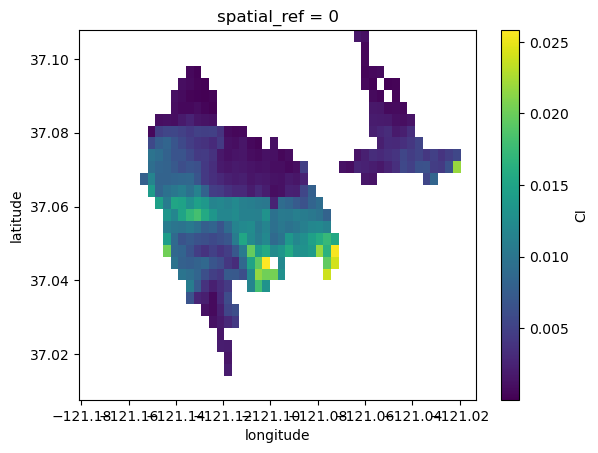

In [17]:
# Plot Both
emit_coarse.where(emit_coarse.land_mask == 1).where(emit_coarse > 0).plot()

In [59]:
# Regression (NEED TO Regression to Implement Regression Checks)
from scipy.stats import linregress
x = emit_coarse.where(emit_coarse.land_mask == 1).where(emit_coarse > 0).values.flatten()
y = np.squeeze(CI.band_data.values).flatten()
df = pd.DataFrame(data={'x':x, 'y':y}).dropna()
slope, intercept, r, p, se = linregress(df.x.values, df.y.values)

Text(0.5, 1.0, 'EMIT CI - Not Convoled to Merged Sentinel 3')

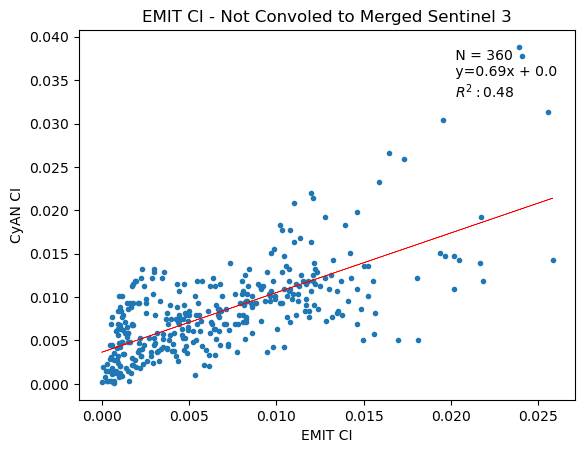

In [72]:
# Visualize
fig,ax = plt.subplots(1,1)
ax.plot(x.flatten(), y.flatten(), '.')
ax.plot(df.x.values, intercept + slope * df.x.values, 'r', linewidth=.5)
ax.set_xlabel('EMIT CI')
ax.set_ylabel('CyAN CI')
ax.text(0.02, 0.033,  f" N = {str(len(df.x))} {chr(10)} y={np.round(slope, 2)}x + {np.round(intercept, 2)} {chr(10)} $R^2:{np.round(r ** 2, 2)}$")
ax.set_title('EMIT CI - Not Convoled to Merged Sentinel 3 CI')